In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
# Random seed
random_seed = 1
np.random.seed(random_seed)

In [3]:
# Load data
from sklearn import datasets
X, y = datasets.make_moons(200, noise = 0.2, random_state = random_seed)
n_of_classes = len(np.unique(y))

In [4]:
# One-hot encode the labels
def one_hot_encoder(y):
    a = np.zeros((len(y), n_of_classes))
    for idx, i in enumerate(y):
        a[idx, int(i)] = 1
    return a

y_coded = one_hot_encoder(y)

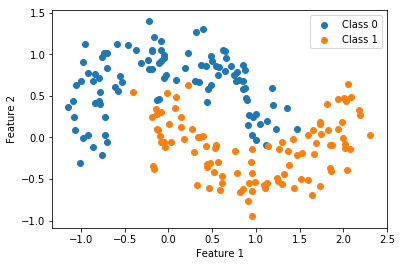

In [5]:
# Visualize the dataset
for i in range(n_of_classes):
    plt.scatter(X[y == i, 0], X[y == i, 1], label = "Class " + str(i))
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [6]:
n_hidden_nodes = 5

w_h = np.random.randn(X.shape[1], n_hidden_nodes)
w_out = np.random.randn(n_hidden_nodes, n_of_classes)
b_h = np.zeros(n_hidden_nodes)
b_out = np.zeros(n_of_classes)
print(w_h)
print(b_h)
print(w_out)
print(b_out)

[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]]
[0. 0. 0. 0. 0.]
[[ 1.46210794 -2.06014071]
 [-0.3224172  -0.38405435]
 [ 1.13376944 -1.09989127]
 [-0.17242821 -0.87785842]
 [ 0.04221375  0.58281521]]
[0. 0.]


In [7]:
# Activation functions
def sigmoid(z):
    return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

In [8]:
def net_input(X, w, b):
    return X.dot(w) + b

In [9]:
# Feed forward operation
def forward_prop(a, w, b):
    net_sum = net_input(a, w, b)
    return sigmoid(net_sum)

In [10]:
a_h = forward_prop(X, w_h, b_h)
a_out = forward_prop(a_h, w_out, b_out)
print(a_out[:5])

[[0.53904062 0.22522229]
 [0.50980408 0.28582953]
 [0.56661593 0.25553019]
 [0.66362922 0.16889504]
 [0.82457337 0.12420901]]


In [11]:
# Cost function
# compute_cost(output_layer_nodes, weight_hidden, weight_out, cost_lambda)
def compute_cost(output):
    term_1 = -y_coded * (np.log(output))
    term_2 = (1. - y_coded) * np.log(1. - output)
    return np.sum(term_1 - term_2)

In [12]:
cost = compute_cost(a_out)
print("Cost: ")
print(cost)

Cost: 
458.2849523492644


In [13]:
def numerical_grad(X, w_h, w_out, e=1e-4):
    numgrad = np.zeros(w_h.shape)
    perturb = np.zeros(w_h.shape)
    
    for i in range(w_h.shape[0]):
        for p in range(w_h.shape[1]):
            perturb[i][p] = e
#             print(perturb)
            a_h = forward_prop(X, w_h + perturb, b_h)
            a_out = forward_prop(a_h, w_out, b_out)
            loss_2 = compute_cost(a_out)

            a_h = forward_prop(X, w_h - perturb, b_h)
            a_out = forward_prop(a_h, w_out, b_out)
            loss_1 = compute_cost(a_out)
            numgrad[i][p] = (loss_2 - loss_1) / (2 * e)
            perturb[i][p] = 0

    return numgrad
numgrad = numerical_grad(X, w_h, w_out)
print(numgrad)

[[ 15.08061418   1.1119137   41.87104616   7.93643453  -7.4663352 ]
 [ -8.68662276   0.39491133 -17.44180404  -3.1809995    2.91595018]]


In [14]:
def compute_grad(X, w_h, w_out):
    a_h = forward_prop(X, w_h, b_h)
    a_out = forward_prop(a_h, w_out, b_out)
    
    sigma_out = a_out - y_coded
    sigmoid_derivative_h = a_h * (1 - a_h)
    sigma_h = (np.dot(sigma_out, w_out.T) * sigmoid_derivative_h)
    
    grad_w_h = np.dot(X.T, sigma_h)
    return grad_w_h
grad = compute_grad(X, w_h, w_out)
print(grad)

[[ 15.08061414   1.1119137   41.87104619   7.93643452  -7.4663352 ]
 [ -8.68662276   0.39491133 -17.44180405  -3.1809995    2.91595019]]


In [15]:
def norm(mat):
    return np.sum(mat ** 2) ** 0.5
norm(grad-numgrad)/norm(grad+numgrad)

5.253850422850456e-10

In [16]:
# Cost function
# compute_cost(output_layer_nodes, weight_hidden, weight_out, cost_lambda)
def compute_cost(output, weight_hidden, weight_out, cost_lambda):
    term_1 = -y_coded * (np.log(output))
    term_2 = (1. - y_coded) * np.log(1. - output)
    regularization = cost_lambda * (np.sum(weight_hidden ** 2.) + np.sum(weight_out) ** 2.)
    return np.sum(term_1 - term_2) + regularization

In [17]:
def train(X, n_epochs, learning_rate, cost_lambda):
    cost_array = []
    w_h = np.random.normal(loc = 0.0, scale = 0.1, size = (X.shape[1] + 1,
                                                             n_hidden_nodes))
    w_out = np.random.normal(loc = 0.0, scale = 0.1, size = (n_hidden_nodes + 1, 
                                                           n_of_classes))

    b_h = w_h[0]
    b_out = w_out[0]
    w_h = w_h[1:]
    w_out = w_out[1:]
    
    for epoch in range(n_epochs + 1):    
        a_h = forward_prop(X, w_h, b_h)
        a_out = forward_prop(a_h, w_out, b_out)

        cost = compute_cost(a_out, w_h, w_out, cost_lambda)
        cost_array.append(cost)

        sigma_out = a_out - y_coded

        # [n_hidden, n_samples] dot [n_samples, n_classlabels]
        # -> [n_hidden, n_classlabels]
        grad_w_out = np.dot(a_h.T, sigma_out)
        grad_b_out = np.sum(sigma_out, axis=0)


        delta_w_out = (grad_w_out + cost_lambda*w_out)
        delta_b_out = grad_b_out  # bias is not regularized
        w_out -= learning_rate * delta_w_out
        b_out -= learning_rate * delta_b_out

        # [n_samples, n_hidden]
        z_2 = X.dot(w_h) + b_h
        sigmoid_derivative_h = sigmoid_grad(z_2)

        # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
        # -> [n_samples, n_hidden]
        sigma_h = (np.dot(sigma_out, w_out.T) *
                   sigmoid_derivative_h)

        # [n_features, n_samples] dot [n_samples, n_hidden]
        # -> [n_features, n_hidden]
        grad_w_h = np.dot(X.T, sigma_h)
        grad_b_h = np.sum(sigma_h, axis=0)

        # Regularization and weight updates
        delta_w_h = (grad_w_h + cost_lambda*w_h)
        delta_b_h = grad_b_h # bias is not regularized
        w_h -= learning_rate * delta_w_h
        b_h -= learning_rate * delta_b_h

        if epoch % 100 == 0:
            sys.stderr.write("\rEpoch: %d\tCost: %f" % (epoch, cost))
            sys.stderr.flush()
    return w_out, w_h, b_out, b_h, cost_array

In [18]:
n_epochs = 20000
learning_rate = 0.01
cost_lambda = 0

In [19]:
def sigmoid_grad(z):
    return sigmoid(z) * (1. - sigmoid(z))

In [20]:
w_out, w_h, b_out, b_h, cost_array = train(X, n_epochs, learning_rate, cost_lambda)

Epoch: 20000	Cost: 9.6631745

In [21]:
from sklearn.metrics import confusion_matrix

def predict(X, weight_hidden, bias_hidden, weight_out, bias_out):
    hidden_layer_nodes = forward_prop(X, weight_hidden, bias_hidden)
    output_layer_nodes = forward_prop(hidden_layer_nodes, weight_out, bias_out)
    y_pred = np.argmax(output_layer_nodes, axis = 1)    
    return y_pred
y_pred = predict(X, w_h, b_h, w_out, b_out)
accuracy = np.mean((y_pred == y)*100)
print("Accuracy =", str(accuracy))

Accuracy = 99.5


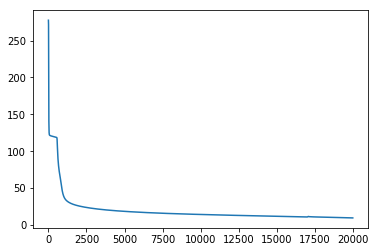

In [22]:
plt.plot(range(len(cost_array)), cost_array)

In [23]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, weight_hidden, bias_hidden, weight_out, bias_out, resolution = 0.01):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Draw the plane
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    
    # Predict using the meshgrid
    Z = predict(np.array([xx1.ravel(), xx2.ravel()]).T, weight_hidden, bias_hidden, weight_out, bias_out)
    Z = Z.reshape(xx1.shape)
    
    # Draw the binary decision range
    plt.contourf(xx1, xx2, Z, alpha = 0.3, cmap = cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot the data
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0], y = X[y == cl, 1], alpha = 0.8, c = colors[idx], marker = markers[idx], label = cl, edgecolor = 'black')


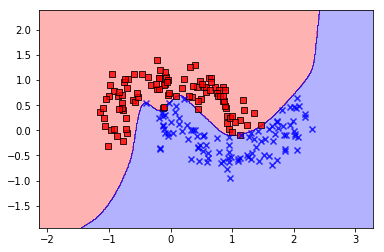

In [24]:
plot_decision_regions(X, y, w_h, b_h, w_out, b_out)